## Downlink Synchronization: UE side implementation

In [1]:
%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import adi
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## Toolkit Libraries

In [3]:
from toolkit5G.PhysicalChannels   import PBCHDecoder
from toolkit5G.SequenceGeneration import DMRS
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.ResourceMapping    import SSB_Grid
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS

## Simulation Parameters

In [4]:
# System Parameters
center_frequency    = 1000e6 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 1024
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(fftSize*4*numSamplesPerSymbol*numOFDMSymbols) 

## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = 20        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP*(fftSize/tfParams.Nfft)).astype(np.int32)    # CP length

In [5]:
# lengthCP[0], N_ID1, N_ID2, ssbIndex[1], hrfBit, nssbCandidatesInHrf = (88, 308, 0, 1, 1, 10)

In [6]:
lengthCP

array([88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72,
       72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72,
       72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72,
       72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72,
       72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88,
       72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72,
       72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72,
       88, 72, 72, 72, 72, 72, 72, 88, 72, 72, 72, 72, 72, 72, 88, 72, 72,
       72, 72, 72, 72], dtype=int32)

## Setup SDR

In [7]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Rx
sdr.gain_control_mode_chan0 = 'slow_attack'
# sdr.rx_hardwaregain_chan0   = 60.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(buffer_size)

## Receive Samples from SDR

In [8]:
# # Clear buffer just to be safe
# for i in range (0, 10):
#     raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# ## Stop transmitting
# sdr.tx_destroy_buffer()

In [9]:
rx_samples.shape

(57344,)

## Time Synchronization: Coarse Tuning

**(rasterOffset, PSS-ID) (392, 0)
**(rasterOffset, PSS-ID) (392, 1)
**(rasterOffset, PSS-ID) (392, 2)


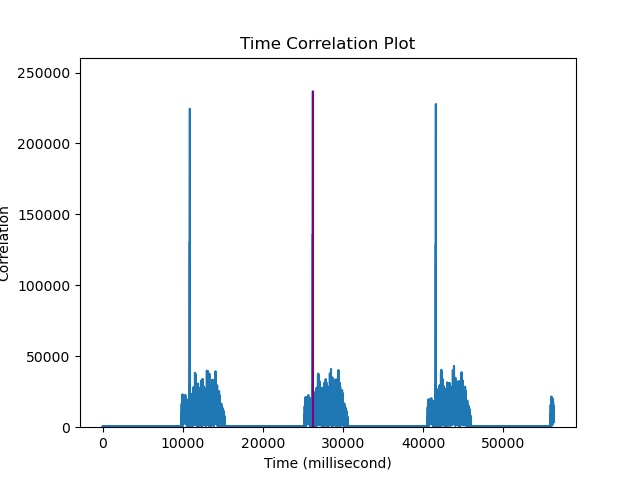

In [10]:
## PSS Detection: Based on time domain PSS Correlation
scsOffset      = 0
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+scsOffset)

pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  N_ID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots()

ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time (millisecond)")
ax.set_ylabel("Correlation")
ax.set_title("Time Correlation Plot")
plt.show()
#________________________________________________________________

In [11]:
pssPeakIndices, freqOffset

(26234, 392)

In [25]:
cpLength   = lengthCP[0] - 15
numSamples = fftSize + cpLength
firstIndex = pssPeakIndices - 5
pssRxTime  = rx_samples[firstIndex: firstIndex + numSamples]

In [26]:
initialSequence = pssRxTime[0:cpLength]
finalSequence   = pssRxTime[fftSize::]

In [27]:
ratio = finalSequence/initialSequence

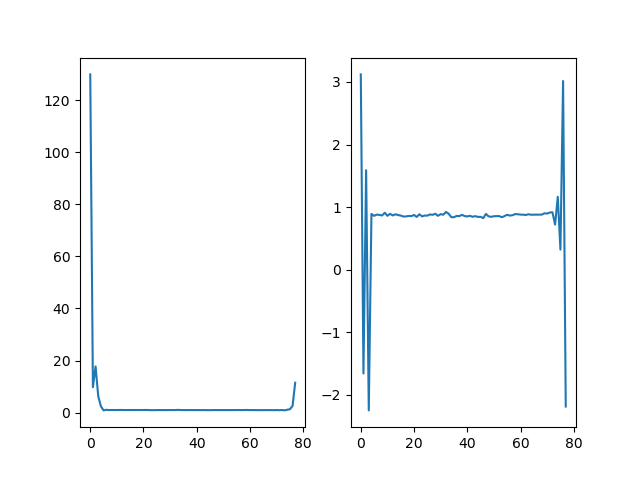

In [28]:
fig, ax = plt.subplots(1,2)

ax[0].plot(np.abs(ratio))
ax[1].plot(np.angle(ratio))

plt.show()

## CFO Estimation

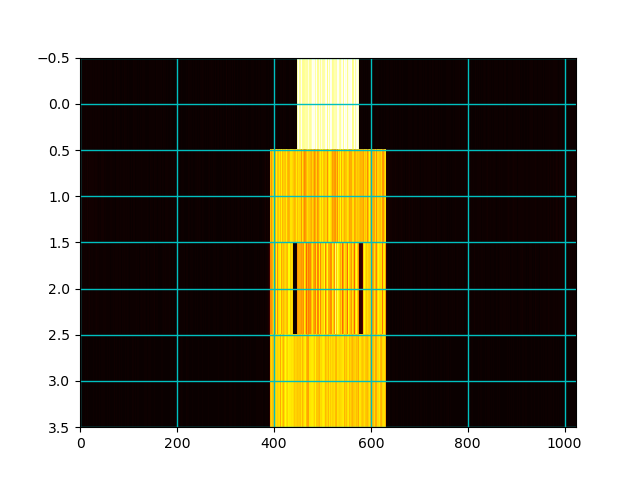

In [16]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices
indices         = np.arange(rx_samples.size)

# Frequency Correction: Fine Tuning
# cfo             = 0
cfo             = np.mean(np.angle(ratio))
rxGrid          = ofdmDemodulator(((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])

# Time Correction: Fine Tuning
# rxGrid          = rxGrid*np.exp(-1j*2*np.pi*fineTune*np.arange(fftSize)/fftSize)

ssbSCSoffset    = int((fftSize-Neff)/2+scsOffset)
ssbEstimate     = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

# Plot Received Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(rxGrid[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
plt.show()

## Extract SSB Grid

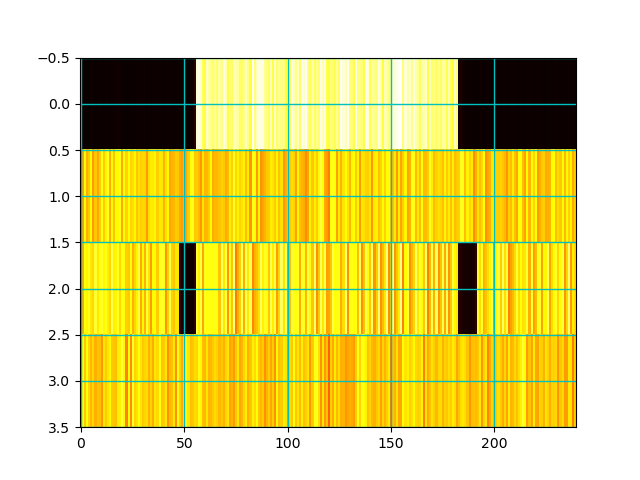

In [44]:
## Extract SSB from Resource Grid
ssbSCSoffset   = int((fftSize-Neff)/2+scsOffset)
ssbEstimate    = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

## Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
plt.show()

## PBCH Processing

* SSS Detection
* PBCH Parameter Estimation
* PBCH Symbol Estimation
* PBCH Decoding


In [45]:
sssDetection   = SSSDetection(method="channelAssisted", N_ID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
nssbCandidatesInHrf = 4
dmrsLen             = 144
dmrsDetection       = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf, dmrsLen)
rssbIndex, rHrfBit  = dmrsDetection(ssbEstimate[0])

rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
## Object for Channel Estimation
chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
rxPBCHIndices  = rxSSBobject.pbchIndices
pbchEstimate   = chanEst(ssbEstimate[0], rxDMRSseq[0], rxDMRSIndices, rxPBCHIndices)

## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "app"
extractMIBinfo = True
pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, 
                             rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

/home/tenet/miniconda3/envs/mysdr/lib/python3.11/site-packages/toolkit5G/ChannelCoder/PolarCoder/polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


## Constellation Diagram: Rx

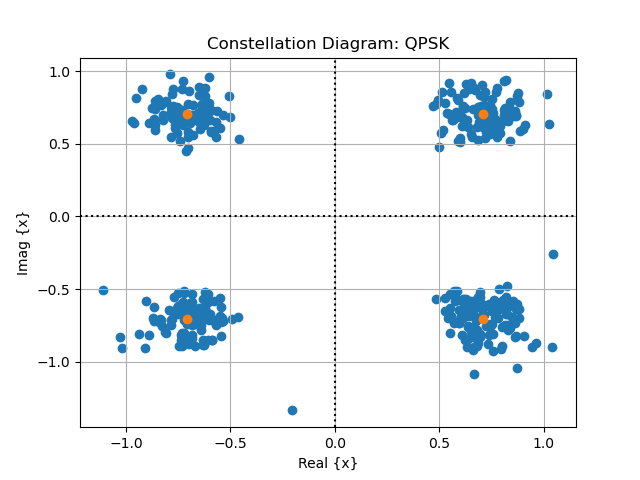

In [46]:
qpsk = np.array([1+1j, 1-1j, -1+1j, -1-1j])/np.sqrt(2)
fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
ax.scatter(np.real(qpsk), np.imag(qpsk), )
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

## MIB and ATI Parameters

In [20]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	14
searchSpace0: 		12
cellBarred: 		notBarred
intraFreqReselection: 	notAllowed
systemFrameNumber: 	533
ssbSubCarrierOffset: 	15
HRFBit: 		0
iSSBindex: 		0


In [21]:
check

array([[ True]])